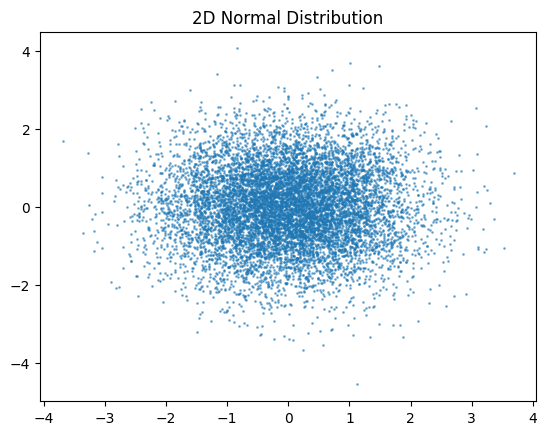

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 生成2D正态分布数据
def generate_normal_data(num_samples, mean, cov):
    data = np.random.multivariate_normal(mean, cov, num_samples)
    return data

# 参数设置
num_samples = 10000
mean = [0, 0]          # 均值
cov = [[1, 0], [0, 1]] # 协方差矩阵（单位矩阵）

# 生成数据
data = generate_normal_data(num_samples, mean, cov)

# 可视化
plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
plt.title("2D Normal Distribution")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 定义UNet模型（简化版）
class SimpleUNet(nn.Module):
    def __init__(self, input_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, input_dim)

    def forward(self, x, t):
        # 简单起见，时间步t未使用（实际实现中需嵌入）
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# 定义扩散过程
class Diffusion:
    def __init__(self, steps=1000, beta_start=1e-4, beta_end=0.02):
        self.steps = steps
        self.betas = torch.linspace(beta_start, beta_end, steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def forward_process(self, x, t):
        noise = torch.randn_like(x)
        alpha_bar = self.alpha_bars[t].view(-1, 1)
        noisy_x = torch.sqrt(alpha_bar) * x + torch.sqrt(1 - alpha_bar) * noise
        return noisy_x, noise

In [ ]:
# 数据准备
dataset = TensorDataset(torch.FloatTensor(data))
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# 初始化模型和扩散
model = SimpleUNet()
diffusion = Diffusion(steps=1000)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 训练循环
num_epochs = 1000
for epoch in range(num_epochs):
    for batch in dataloader:
        x = batch[0]
        t = torch.randint(0, diffusion.steps, (x.shape[0],))
        noisy_x, true_noise = diffusion.forward_process(x, t)
        pred_noise = model(noisy_x, t)
        loss = criterion(pred_noise, true_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.2954
Epoch 100, Loss: 0.1322
Epoch 200, Loss: 0.4045
Epoch 300, Loss: 0.1631
Epoch 400, Loss: 0.1847
Epoch 500, Loss: 0.3664
Epoch 600, Loss: 0.4885
Epoch 700, Loss: 0.1026
Epoch 800, Loss: 0.6982
Epoch 900, Loss: 0.2866


In [ ]:
def sample(model, diffusion, num_samples=1000):
    model.eval()
    samples = torch.randn(num_samples, 2)  # 从标准正态分布开始
    for t in reversed(range(diffusion.steps)):
        with torch.no_grad():
            noise_pred = model(samples, torch.full((num_samples,), t))
        alpha = diffusion.alphas[t]
        alpha_bar = diffusion.alpha_bars[t]
        noise = torch.randn_like(samples) if t > 0 else 0
        samples = (1 / torch.sqrt(alpha)) * (
            samples - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * noise_pred
        ) + torch.sqrt(diffusion.betas[t]) * noise
    return samples.numpy()

generated_data = sample(model, diffusion)

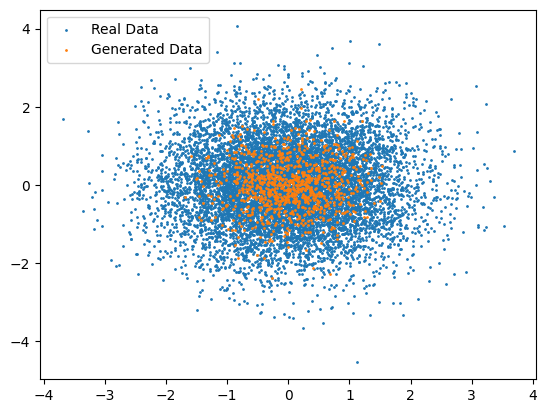

In [ ]:
plt.scatter(data[:, 0], data[:, 1], s=1, label="Real Data")
plt.scatter(generated_data[:, 0], generated_data[:, 1], s=1, label="Generated Data")
plt.legend()
plt.show()

In [ ]:
from scipy.stats import wasserstein_distance

# 计算Wasserstein距离（1D投影）
w_dist_x = wasserstein_distance(data[:, 0], generated_data[:, 0])
w_dist_y = wasserstein_distance(data[:, 1], generated_data[:, 1])
print(f"Wasserstein Distance (X): {w_dist_x:.4f}")
print(f"Wasserstein Distance (Y): {w_dist_y:.4f}")

Wasserstein Distance (X): 0.3213
Wasserstein Distance (Y): 0.3002


In [ ]:
from scipy.stats import entropy

def kl_divergence(real, fake, bins=100):
    real_hist = np.histogramdd(real, bins=bins, density=True)[0]
    fake_hist = np.histogramdd(fake, bins=bins, density=True)[0]
    return entropy(real_hist + 1e-10, fake_hist + 1e-10)

kl = kl_divergence(data, generated_data)
print(f"KL Divergence: {kl:.4f}")

TypeError: unsupported format string passed to numpy.ndarray.__format__